## Import libraries

In [2]:
import sys, os

basepath = os.path.abspath("../..")
sys.path.append(basepath)
sys.path.append(basepath + "/Operators")
sys.path.append(basepath + "/Utilities")

figdir = basepath + "/Fig/"
datadir = basepath + "/Data/"

import numpy as np
import scipy as sp
import time
import matplotlib.pyplot as plt
%matplotlib inline

import DevitoOperators
from DevitoUtils import create_model, plot_image, plot_image_xy, plot_images_grid_xy, plot_shotrecord
from Utils import ricker_time, extrapolate_same
from examples.seismic.acoustic import AcousticWaveSolver
from examples.seismic import plot_velocity, plot_perturbation, demo_model, AcquisitionGeometry

from devito import configuration
configuration['log-level'] = 'WARNING'

from devito import configuration
configuration['log-level'] = 'WARNING'

## Scale factor 1.0

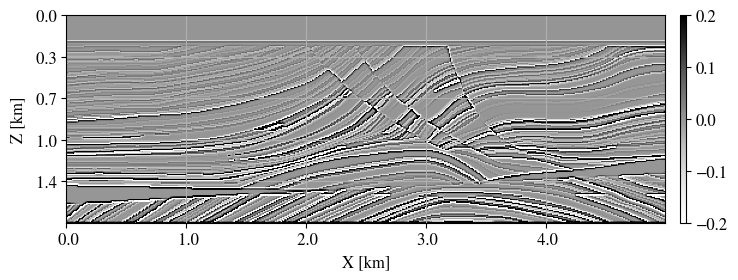

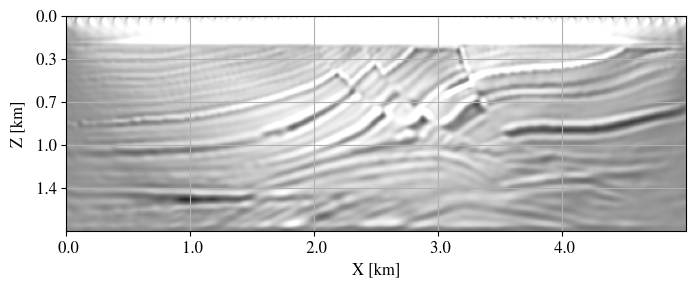

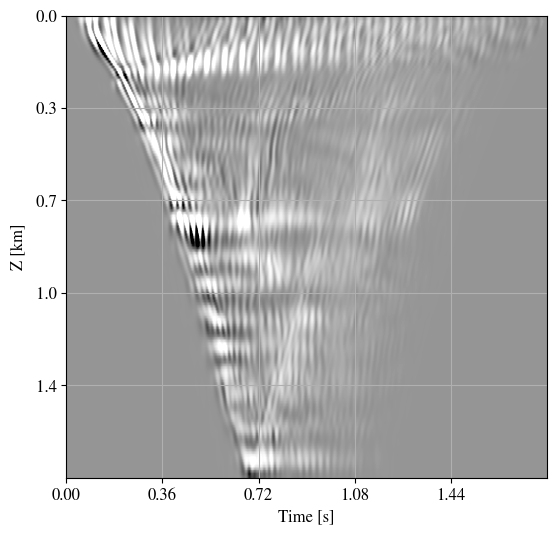

In [3]:
# Load Marmousi model
nx = 500
nz = 174
with np.load(datadir + "marmousi-vp.npz") as data:
    vp = data["arr_0"]

cig_aspect = 1.0

def marmousi_cig(scale_fac, filestr):

    filestr = filestr + "_scalefac_" + "{:4.2f}".format(scale_fac)

    # Create params dicts
    params = {
        "Nx": nx,
        "Nz": nz,
        "Nt": 100,  # this has to be updated later
        "nbl": 75,
        "Ns": 50,
        "Nr": nz,
        "so": 4,
        "to": 2
    }

    # Create velocity
    vp_pad = np.zeros(shape=(2 * params["nbl"] + params["Nx"], 2 * params["nbl"] + params["Nz"]), dtype=np.float32)
    vp_pad[params["nbl"]: params["nbl"] + params["Nx"], params["nbl"]: params["nbl"] + params["Nz"]] = vp / 1000.0
    extrapolate_same(array2d=vp_pad,  ncells_pad_x=params["nbl"], ncells_pad_z=params["nbl"], create_new=False)
    smooth_filt = np.array([[1, 1, 1], [1, 1, 1], [1, 1, 1]], dtype=np.float32) / 9.0
    vp_pad_smooth = sp.signal.convolve2d(in1=vp_pad, in2=smooth_filt, mode="same", boundary="symm")

    vel = create_model(shape=(params["Nx"], params["Nz"]))
    vel.vp.data[:, :] = vp_pad_smooth

    # Simulation time, wavelet
    t0 = 0.
    tn = 1800.  # Simulation last 2 second (2000 ms)
    f0 = 0.015  # Source peak frequency is 15Hz (0.015 kHz)

    # Reflection acquisition geometry (sources and receivers are equally spaced in X direction)
    src_depth = 20.0  # Depth is 20m
    rec_depth = 20.0  # Depth is 20m

    src_coord = np.empty((params["Ns"], 2))
    src_coord[:, 0] = np.linspace(0, vel.domain_size[0], num=params["Ns"])
    src_coord[:, 1] = src_depth

    rec_coord = np.empty((params["Nr"], 2))
    rec_coord[:, 0] = np.linspace(0, vel.domain_size[0], num=params["Nr"])
    rec_coord[:, 1] = rec_depth

    # Create the geometry objects for background velocity models
    src_dummy = np.empty((1, 2))
    src_dummy[0, :] = src_coord[int(src_coord.shape[0] / 2), :]
    geometry = AcquisitionGeometry(vel, rec_coord, src_dummy, t0, tn, f0=f0, src_type='Ricker')
    params["Nt"] = geometry.nt
    del src_dummy

    # Define a solver object
    solver = AcousticWaveSolver(vel, geometry, space_order=params["so"])

    # Create perturbation
    dm_scale = 2.0
    dm = np.zeros((params["Nt"], params["Nx"], params["Nz"]), dtype=np.float32)
    for i in range(params["Nt"]):
        dm[i, :, :] = vp_pad[
            params["nbl"]: params["nbl"] + params["Nx"],
            params["nbl"]: params["nbl"] + params["Nz"]
        ] - vp_pad_smooth[
            params["nbl"]: params["nbl"] + params["Nx"],
            params["nbl"]: params["nbl"] + params["Nz"]
        ]
        
    plot_image_xy(
            dm[100, :, :].T,
            x0=vel.origin[0], xn=vel.origin[0] + vel.domain_size[0],
            y0=vel.origin[1], yn=vel.origin[1] + vel.domain_size[1],
            scale=dm_scale / 10, clip=1.0, colorbar=True,
            ylabel="Z [km]", xlabel="X [km]",
            grid="on", aspect="equal",
            fontname="STIXGeneral", fontsize=12,
            savefig_fname=figdir + filestr + "_model_pert.pdf"
    )

    # Perform Born modeling and generate data
    td_born_data_true = np.zeros((params["Ns"], params["Nt"], params["Nr"]), dtype=np.float32)
    DevitoOperators.td_born_forward(
        model_pert=dm,
        born_data=td_born_data_true,
        src_coords=src_coord,
        vel=vel,
        geometry=geometry,
        solver=solver,
        params=params
    )
    
    # Create scaled models
    vel1 = create_model(shape=(params["Nx"], params["Nz"]))
    vel1.vp.data[:, :] = vp_pad_smooth * scale_fac

    # Image the data
    dm_image = np.zeros((params["Nt"], params["Nx"], params["Nz"]), dtype=np.float32)
    DevitoOperators.td_born_adjoint(
        born_data=td_born_data_true,
        model_pert=dm_image,
        src_coords=src_coord,
        vel=vel1,
        geometry=geometry,
        solver=solver,
        params=params
    )
    
    # Plot stacked image
    plot_image_xy(
        np.sum(dm_image, axis=0).T,
        x0=vel.origin[0], xn=vel.origin[0] + vel.domain_size[0],
        y0=vel.origin[1], yn=vel.origin[1] + vel.domain_size[1],
        scale=None, sfac=0.3, clip=1.0, colorbar=False,
        ylabel="Z [km]", xlabel="X [km]",
        grid="on", aspect="equal",
        fontname="STIXGeneral", fontsize=12,
        savefig_fname=figdir + filestr + "_stacked_image.pdf"
    )

    # Plot CIG at middle of horizontal grid
    cig = dm_image[:, int(params["Nx"] / 2), :].T
    plot_image_xy(
        cig,
        x0=t0, xn=tn,
        y0=vel.origin[1], yn=vel.origin[1] + vel.domain_size[1],
        scale=dm_scale, clip=1.0, colorbar=False,
        ylabel="Z [km]", xlabel="Time [s]", xticklabels_fmt="{:4.2f}",
        grid="on", aspect=cig_aspect,
        fontname="STIXGeneral", fontsize=12,
        savefig_fname=figdir + filestr + "_cig.pdf"
    )
    
    return dm_image

dm_image = marmousi_cig(scale_fac=1.0, filestr="p02_marmousi_cig")

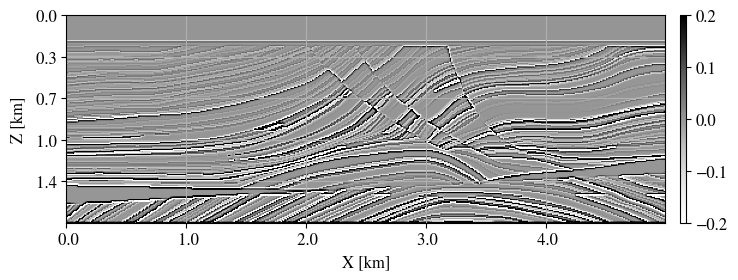

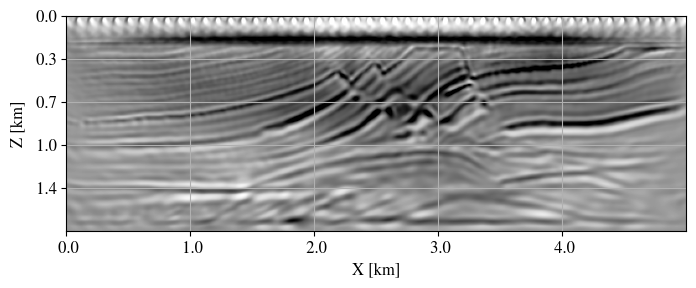

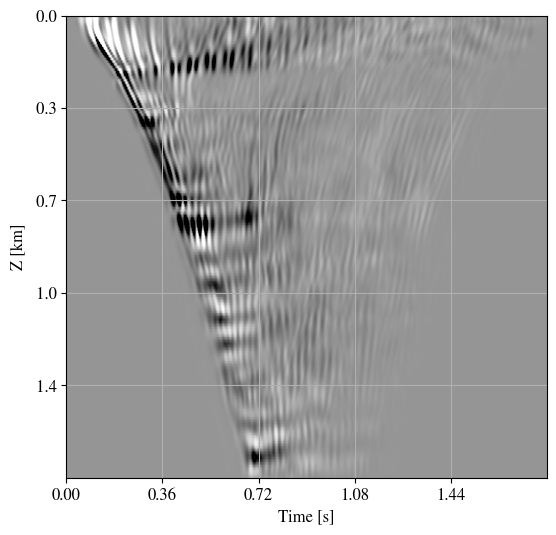

Done


In [4]:
dm_image_minus5 = marmousi_cig(scale_fac=0.95, filestr="p02_marmousi_cig")
print("Done")

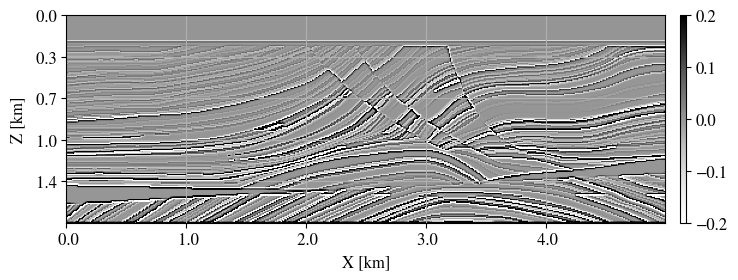

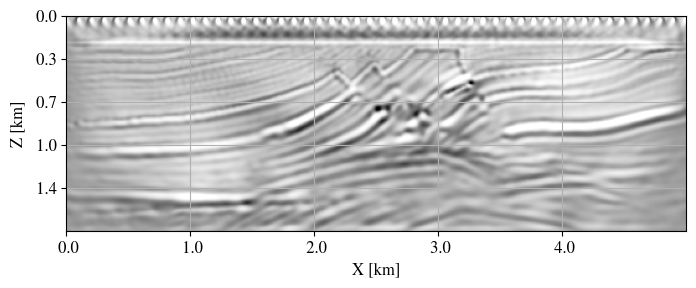

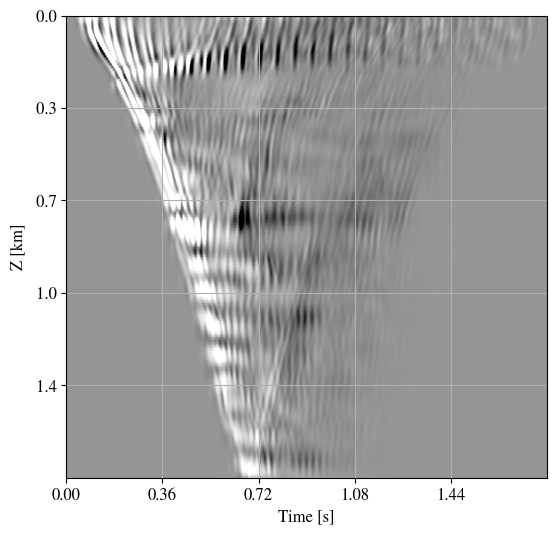

Done


In [7]:
dm_image_plus5 = marmousi_cig(scale_fac=1.03, filestr="p02_marmousi_cig")
print("Done")

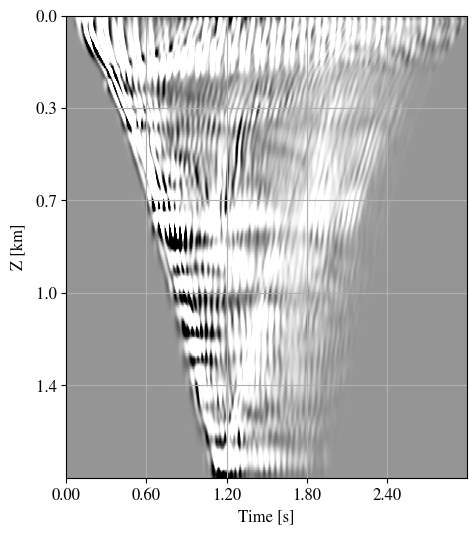

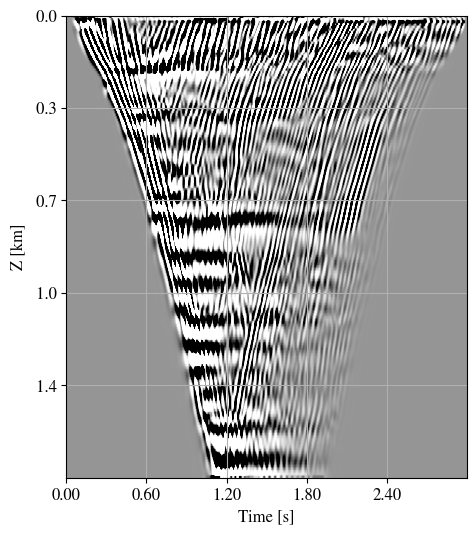

In [13]:
params = {
    "Nx": nx,
    "Nz": nz,
    "Nt": 100,  # this has to be updated later
    "nbl": 75,
    "Ns": 200,
    "Nr": nz,
    "so": 4,
    "to": 2
}

vel = create_model(shape=(params["Nx"], params["Nz"]))
vel.vp.data[:, :] = 2.0

# Simulation time, wavelet
t0 = 0.
tn = 3000.  # Simulation last 2 second (2000 ms)

cig_aspect = 2.0
dm_scale = 1
scale_fac = 1.0
filestr = "p02_marmousi_cig_scalefac_" + "{:4.2f}".format(scale_fac)

# Plot CIG at middle of horizontal grid
cig = dm_image[:, int(params["Nx"] / 2), :].T

plot_image_xy(
    cig,
    x0=t0, xn=tn,
    y0=vel.origin[1], yn=vel.origin[1] + vel.domain_size[1],
    scale=dm_scale, clip=1.0, colorbar=False,
    ylabel="Z [km]", xlabel="Time [s]", xticklabels_fmt="{:4.2f}",
    grid="on", aspect=cig_aspect,
    fontname="STIXGeneral", fontsize=12,
    savefig_fname=figdir + filestr + "_cig.pdf"
)

plot_image_xy(
    sp.ndimage.laplace(cig, mode="nearest",),
    x0=t0, xn=tn,
    y0=vel.origin[1], yn=vel.origin[1] + vel.domain_size[1],
    scale=dm_scale/10, clip=1.0, colorbar=False,
    ylabel="Z [km]", xlabel="Time [s]", xticklabels_fmt="{:4.2f}",
    grid="on", aspect=cig_aspect,
    fontname="STIXGeneral", fontsize=12,
    savefig_fname=figdir + filestr + "_cig.pdf"
)

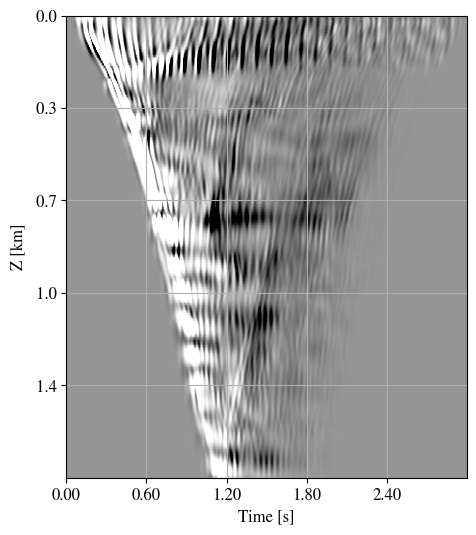

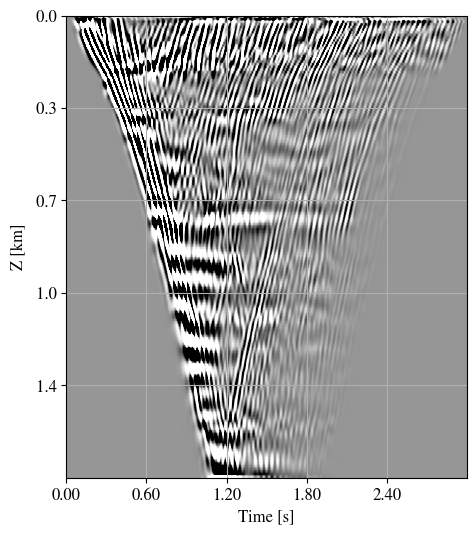

In [14]:
# Plot CIG at middle of horizontal grid
cig = dm_image_plus5[:, int(params["Nx"] / 2), :].T

plot_image_xy(
    cig,
    x0=t0, xn=tn,
    y0=vel.origin[1], yn=vel.origin[1] + vel.domain_size[1],
    scale=dm_scale, clip=1.0, colorbar=False,
    ylabel="Z [km]", xlabel="Time [s]", xticklabels_fmt="{:4.2f}",
    grid="on", aspect=cig_aspect,
    fontname="STIXGeneral", fontsize=12,
    savefig_fname=figdir + filestr + "_cig.pdf"
)

plot_image_xy(
    sp.ndimage.laplace(cig, mode="nearest",),
    x0=t0, xn=tn,
    y0=vel.origin[1], yn=vel.origin[1] + vel.domain_size[1],
    scale=dm_scale/10, clip=1.0, colorbar=False,
    ylabel="Z [km]", xlabel="Time [s]", xticklabels_fmt="{:4.2f}",
    grid="on", aspect=cig_aspect,
    fontname="STIXGeneral", fontsize=12,
    savefig_fname=figdir + filestr + "_cig.pdf"
)

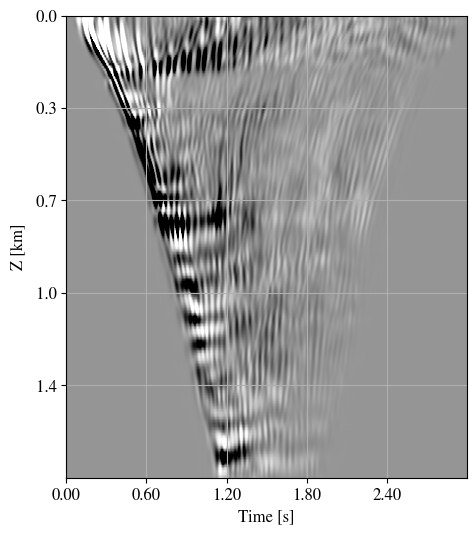

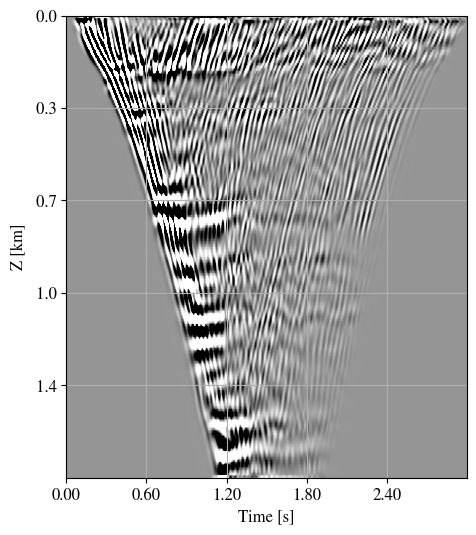

In [16]:
# Plot CIG at middle of horizontal grid
cig = dm_image_minus5[:, int(params["Nx"] / 2), :].T

plot_image_xy(
    cig,
    x0=t0, xn=tn,
    y0=vel.origin[1], yn=vel.origin[1] + vel.domain_size[1],
    scale=dm_scale, clip=1.0, colorbar=False,
    ylabel="Z [km]", xlabel="Time [s]", xticklabels_fmt="{:4.2f}",
    grid="on", aspect=cig_aspect,
    fontname="STIXGeneral", fontsize=12,
    savefig_fname=figdir + filestr + "_cig.pdf"
)

plot_image_xy(
    sp.ndimage.laplace(cig, mode="nearest",),
    x0=t0, xn=tn,
    y0=vel.origin[1], yn=vel.origin[1] + vel.domain_size[1],
    scale=dm_scale/10, clip=1.0, colorbar=False,
    ylabel="Z [km]", xlabel="Time [s]", xticklabels_fmt="{:4.2f}",
    grid="on", aspect=cig_aspect,
    fontname="STIXGeneral", fontsize=12,
    savefig_fname=figdir + filestr + "_cig.pdf"
)